In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from utils import print_score
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

In [147]:
train = pd.read_csv('train.csv').drop('ID', axis=1)
test = pd.read_csv('test.csv').drop('ID', axis=1)
submission = pd.read_csv('sample_submission.csv')

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   first_party         2478 non-null   object
 1   second_party        2478 non-null   object
 2   facts               2478 non-null   object
 3   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 77.6+ KB


In [149]:
print('first_party의 종류 개수 : ',train['first_party'].nunique())
print('first_party sample 7건 : \n', train['first_party'][:7])

first_party의 종류 개수 :  2110
first_party sample 7건 : 
 0              Phil A. St. Amant
1                 Stephen Duncan
2              Billy Joe Magwood
3                     Linkletter
4             William Earl Fikes
5    C & A Carbone, Inc., et al.
6         David Jennings, et al.
Name: first_party, dtype: object


In [150]:
print('second_party의 종류 개수 : ',train['second_party'].nunique())
print('second_party sample 7건 : \n', train['second_party'][:7])

second_party의 종류 개수 :  1974
second_party sample 7건 : 
 0                Herman A. Thompson
1                    Lawrence Owens
2    Tony Patterson, Warden, et al.
3                            Walker
4                           Alabama
5                Town of Clarkstown
6       Alejandro Rodriguez, et al.
Name: second_party, dtype: object


In [151]:
pd.set_option('max_colwidth',200)
print('facts 평균 문자열 크기 : ', train['facts'].str.len().mean())

train['facts'][:2]

facts 평균 문자열 크기 :  1109.0564971751412


0    On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Commun...
1    Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lin...
Name: facts, dtype: object

In [152]:
# train, test 문자열 데이터의 좌우 공백 제거하기
for col in train.columns[:-1]:
    train[col] = train[col].str.strip()
for col in test.columns:
    test[col] = test[col].str.strip()


# 1) et al. , inc. 포함 여부로 회사, 단체 여부 확인

# train_first
lst_many = []
lst_company = []

for first in train['first_party']:
    if "et al." in first:
        lst_many.append(1)
    else:
        lst_many.append(0)

    if "Inc." in first:
        lst_company.append(1)
    else:
        lst_company.append(0)

train['first_many'] = lst_many
train['first_company'] = lst_company

# test_first
lst_many = []
lst_company = []

for first in test['first_party']:
    if "et al." in first:
        lst_many.append(1)
    else:
        lst_many.append(0)

    if "Inc." in first:
        lst_company.append(1)
    else:
        lst_company.append(0)

test['first_many'] = lst_many
test['first_company'] = lst_company

# train_second
lst_many = []
lst_company = []

for second in train['second_party']:
    if "et al." in second:
        lst_many.append(1)
    else:
        lst_many.append(0)

    if "Inc." in second:
        lst_company.append(1)
    else:
        lst_company.append(0)

train['second_many'] = lst_many
train['second_company'] = lst_company

# test_second
lst_many = []
lst_company = []

for second in test['second_party']:
    if "et al." in second:
        lst_many.append(1)
    else:
        lst_many.append(0)

    if "Inc." in second:
        lst_company.append(1)
    else:
        lst_company.append(0)

test['second_many'] = lst_many
test['second_company'] = lst_company

In [155]:
lb_first_many = LabelBinarizer(sparse_output=True)
train_first_many = lb_first_many.fit_transform(train['first_many'])
test_first_many = lb_first_many.transform(test['first_many'])

lb_first_company = LabelBinarizer(sparse_output=True)
train_first_company = lb_first_company.fit_transform(train['first_company'])
test_first_company = lb_first_company.transform(test['first_company'])

lb_second_many = LabelBinarizer(sparse_output=True)
train_second_many = lb_second_many.fit_transform(train['second_many'])
test_second_many = lb_second_many.transform(test['second_many'])

lb_second_company = LabelBinarizer(sparse_output=True)
train_second_company = lb_second_company.fit_transform(train['second_company'])
test_second_company = lb_second_company.transform(test['second_company'])

In [163]:
print('<train')
print('lb first shape : ', train_first_many.shape, train_first_company.shape)
print('lb second shape : ', train_second_many.shape, train_second_company.shape)
print('='*50)
print('<test>')
print('lb first shape : ', test_first_many.shape, test_first_company.shape)
print('lb second shape : ', test_second_many.shape, test_second_company.shape)

<train
lb first shape :  (2478, 1) (2478, 1)
lb second shape :  (2478, 1) (2478, 1)
<test>
lb first shape :  (1240, 1) (1240, 1)
lb second shape :  (1240, 1) (1240, 1)


In [160]:
# first_party, second_party 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(train.first_party)
test_1 = cnt_vec.transform(test.first_party)

cnt_vec2 = CountVectorizer()
X_name2 = cnt_vec2.fit_transform(train.second_party)
X_name2.resize(2478,2937)
test_2 = cnt_vec.transform(test.second_party)

# facts 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(train.facts)
test_descp = tfidf_descp.transform(test.facts)

In [161]:
print('<train>')
print('first_party shape : ', X_name.shape)
print('second_party shape : ', X_name2.shape)
print('facts shape : ', X_descp.shape)
print('='*50)
print('<test>')
print('first_party shape : ', test_1.shape)
print('second_party shape : ', test_2.shape)
print('facts shape : ', test_descp.shape)

<train>
first_party shape :  (2478, 2937)
second_party shape :  (2478, 2937)
facts shape :  (2478, 50000)
<test>
first_party shape :  (1240, 2937)
second_party shape :  (1240, 2937)
facts shape :  (1240, 50000)


In [164]:
train_lst = (X_name, X_name2, X_descp, train_first_many, train_first_company, train_second_many, train_second_company)
test_lst = (test_1, test_2, test_descp, test_first_many, test_first_company, test_second_many, test_second_company)

train_sparse = hstack(train_lst).tocsr()
test_sparse = hstack(test_lst).tocsr()

In [165]:
train_sparse

<2478x55878 sparse matrix of type '<class 'numpy.float64'>'
	with 309572 stored elements in Compressed Sparse Row format>

In [166]:
test_sparse

<1240x55878 sparse matrix of type '<class 'numpy.float64'>'
	with 128110 stored elements in Compressed Sparse Row format>

In [198]:
ada = ADASYN(random_state=42)
x_res, y_res = ada.fit_resample(train_sparse, train['first_party_winner'])

In [203]:
y_res.value_counts()

1    1649
0    1628
Name: first_party_winner, dtype: int64

In [204]:
X_train, X_val, Y_train, Y_val = train_test_split(x_res, y_res, test_size=.2, random_state=42, stratify=y_res)
X_test = test_sparse

In [205]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

linear_model.fit(X_train, Y_train)
preds = linear_model.predict(X_val)
preds = np.where(preds>.5, 1, 0)
print('Ridge')
print_score(Y_val, preds)

Ridge
<Accuracy Score>
0.7088414634146342
<F1-Score>
0.6508226691042048
<Roc-Auc Score>
0.7098810187767244



In [206]:
print(confusion_matrix(Y_val, preds))

[[287  39]
 [152 178]]


In [207]:
print(classification_report(Y_val, preds))

              precision    recall  f1-score   support

           0       0.65      0.88      0.75       326
           1       0.82      0.54      0.65       330

    accuracy                           0.71       656
   macro avg       0.74      0.71      0.70       656
weighted avg       0.74      0.71      0.70       656



In [212]:
lgbm_model = LGBMClassifier(n_estimators=2000, learning_rate=.01, num_leaves=125, random_state=42,
                            objective='binary', metric='binary')

lgbm_model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], early_stopping_rounds=200, verbose=100)
preds = lgbm_model.predict(X_val)

print('LGBM')
print_score(Y_val, preds)

c:\jhs_pr\jhs_tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\jhs_pr\jhs_tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's binary_logloss: 0.432169	valid_1's binary_logloss: 0.582493
[200]	training's binary_logloss: 0.285628	valid_1's binary_logloss: 0.519648
[300]	training's binary_logloss: 0.192167	valid_1's binary_logloss: 0.491661
[400]	training's binary_logloss: 0.130604	valid_1's binary_logloss: 0.476802
[500]	training's binary_logloss: 0.0901774	valid_1's binary_logloss: 0.472626
[600]	training's binary_logloss: 0.0628518	valid_1's binary_logloss: 0.471872
[700]	training's binary_logloss: 0.0441131	valid_1's binary_logloss: 0.47646
LGBM
<Accuracy Score>
0.7804878048780488
<F1-Score>
0.791907514450867
<Roc-Auc Score>
0.7801821899981409



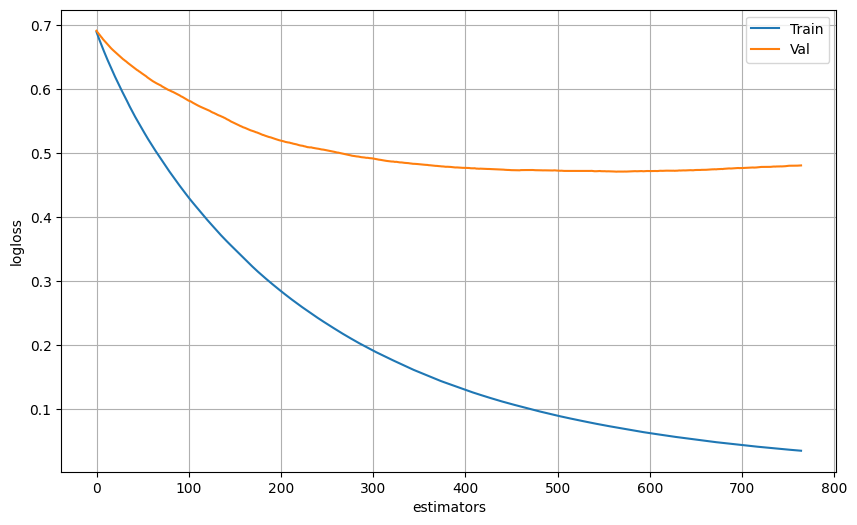

In [216]:
plt.figure(figsize=(10,6))
plt.plot(lgbm_model.evals_result_['training']['binary_logloss'])
plt.plot(lgbm_model.evals_result_['valid_1']['binary_logloss'])
plt.legend(['Train','Val'])
plt.xlabel('estimators')
plt.ylabel('logloss')
# plt.yticks(np.arange(4,6.4,step=.5))
# plt.xticks(np.arange(0,1000,step=50))
plt.grid()

In [211]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_val, preds))
print(confusion_matrix(Y_val, preds))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       326
           1       0.76      0.83      0.79       330

    accuracy                           0.78       656
   macro avg       0.78      0.78      0.78       656
weighted avg       0.78      0.78      0.78       656

[[238  88]
 [ 56 274]]


In [219]:
submission['first_party_winner'] = lgbm_model.predict(X_test)
submission.to_csv('./lgbm_over.csv', index=False)

In [217]:
XGB_model = XGBClassifier(n_estimators=2000, learning_rate=.5, num_leaves=125, random_state=42,
                          objective='binary:logistic', eval_metric='auc')

XGB_model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], early_stopping_rounds=1000, verbose=100)
preds = XGB_model.predict(X_val)
print('XGB')
print_score(Y_val, preds)

[15:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[0]	validation_0-auc:0.70234	validation_1-auc:0.67358


c:\jhs_pr\jhs_tf\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-auc:1.00000	validation_1-auc:0.80982
[200]	validation_0-auc:1.00000	validation_1-auc:0.81135
[300]	validation_0-auc:1.00000	validation_1-auc:0.80622
[400]	validation_0-auc:1.00000	validation_1-auc:0.80344
[500]	validation_0-auc:1.00000	validation_1-auc:0.80569
[600]	validation_0-auc:1.00000	validation_1-auc:0.80500
[700]	validation_0-auc:1.00000	validation_1-auc:0.80323
[800]	validation_0-auc:1.00000	validation_1-auc:0.80292
[900]	validation_0-auc:1.00000	validation_1-auc:0.80265
[1000]	validation_0-auc:1.00000	validation_1-auc:0.80235
[1100]	validation_0-auc:1.00000	validation_1-auc:0.80146
[1162]	validation_0-auc:1.00000	validation_1-auc:0.80168
XGB
<Accuracy Score>
0.7347560975609756
<F1-Score>
0.7418397626112759
<Roc-Auc Score>
0.7346160996467744



In [218]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_val, preds))
print(confusion_matrix(Y_val, preds))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       326
           1       0.73      0.76      0.74       330

    accuracy                           0.73       656
   macro avg       0.74      0.73      0.73       656
weighted avg       0.74      0.73      0.73       656

[[232  94]
 [ 80 250]]
